In [78]:
import pandas as pd
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

In [77]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="IPython")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="IPython")

In [79]:
tokenizer = TweetTokenizer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'https?://\S+', 'link', text)  # Replace URLs with 'link'
    text = re.sub(r'@\w+', 'mention', text)  # Replace @mentions
    text = re.sub(r'\b\d+(\.\d+)?[kKmM]?\b', 'number', text)  # Replace numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Clean extra spaces
    return text

def count_emojis(text):
    return sum(1 for char in text if char in emoji.EMOJI_DATA)

def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

def has_link(text):
    return 'link' in text

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

def get_top_common_words(tokens_list, top_n=20):
    all_words = []
    for tokens in tokens_list:
        all_words.extend(tokens)
    common_words = [word for word, freq in Counter(all_words).most_common(top_n)]
    return set(common_words)

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def plot_histogram(data, column, title, xlabel):
    sns.histplot(data=data, x=column, hue='label', element='step', stat='density', common_norm=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()

def plot_top_hashtags(hashtag_counter, title, top_n=10):
    hashtags, counts = zip(*hashtag_counter.most_common(top_n))
    hashtag_df = pd.DataFrame({'Hashtag': hashtags, 'Count': counts})

    plt.figure(figsize=(8,6))
    sns.barplot(data=hashtag_df, x='Count', y='Hashtag')
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Hashtag')

    max_count = max(counts)
    plt.xlim(0, max_count * 3)

    plt.show()

def plot_sentiment_distribution(data):
    plt.figure(figsize=(8,6))
    sns.countplot(data=data, x='sentiment_label', hue='label', order=['positive', 'negative', 'neutral'])
    plt.title('Sentiment Label Distribution by Tweet Type')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

def count_sentiment_by_label(df):
    counts = df.groupby(['label', 'sentiment_label']).size().reset_index(name='count')
    print("\n--- Number of Tweets by Label and Sentiment ---")
    print(counts)
    return counts

def plot_link_distribution(df):
  plt.figure(figsize=(6,4))
  sns.countplot(data=df, x='has_link', hue='label')
  plt.title('Distribution of Links in Tweets by Label')
  plt.xlabel('Contains Link')
  plt.ylabel('Count')
  plt.tight_layout()
  plt.show()


In [80]:
df = pd.read_csv("/Users/samreade/Desktop/COMM 188C/full.csv")
#df = pd.read_csv("/content/full.csv")
df['raw_tweet'] = df['tweet']
df['tweet'] = df['tweet'].apply(preprocess_text)
df['tokens'] = df['tweet'].apply(tokenizer.tokenize)
standard_stopwords = set(stopwords.words('english'))
common_words = get_top_common_words(df['tokens'], top_n=20)
print(f"Top common words (before adding stopwords): {common_words}")

Top common words (before adding stopwords): {'mention', 'a', 'on', 'number', ':', 'for', 'that', 'in', '.', '?', 'the', 'and', 'to', 'of', 'are', 'cases', 'link', '#covid19', 'is', 'covid-number'}


In [81]:
def run_eda(df):

    df['post_length'] = df['tokens'].apply(len)
    df['emoji_count'] = df['tweet'].apply(count_emojis)
    df['hashtag_count'] = df['raw_tweet'].apply(count_hashtags)
    df['has_link'] = df['tweet'].apply(has_link)
    df['sentiment'] = df['tweet'].apply(get_sentiment)
    df['sentiment_label'] = df['sentiment'].apply(classify_sentiment)

    real_tokens = [word for tokens in df[df['label'] == 'real']['tokens_clean'] for word in tokens]
    fake_tokens = [word for tokens in df[df['label'] == 'fake']['tokens_clean'] for word in tokens]

    real_tokens = [word for word in real_tokens if not word.startswith('#')]
    fake_tokens = [word for word in fake_tokens if not word.startswith('#')]
    plot_wordcloud(' '.join(real_tokens), 'Real news')
    plot_wordcloud(' '.join(fake_tokens), 'Fake news')

    plot_histogram(df, 'post_length', 'Post Length Distribution', 'Number of Words')
    plot_histogram(df, 'emoji_count', 'Emoji Count Distribution', 'Number of Emojis')
    plot_histogram(df, 'hashtag_count', 'Hashtag Count Distribution', 'Number of Hashtags')
    plot_histogram(df, 'sentiment', 'Sentiment Distribution', 'Sentiment Polarity')

    real_hashtags = Counter([tag for tweet in df[df['label']=='real']['raw_tweet'] for tag in re.findall(r'#\w+', tweet)])
    fake_hashtags = Counter([tag for tweet in df[df['label']=='fake']['raw_tweet'] for tag in re.findall(r'#\w+', tweet)])
    plot_top_hashtags(real_hashtags, 'Top Hashtags - Real Tweets', top_n=15)
    plot_top_hashtags(fake_hashtags, 'Top Hashtags - Fake Tweets', top_n=15)

    real_words = Counter(real_tokens)
    fake_words = Counter(fake_tokens)

    print("\n--- Top Words in Real Tweets (after removing common words) ---")
    print([word for word in real_words.most_common(20)])

    print("\n--- Top Words in Fake Tweets (after removing common words) ---")
    print([word for word in fake_words.most_common(20)])

    plot_sentiment_distribution(df)
    plot_link_distribution(df)


    sentiment_counts = count_sentiment_by_label(df)

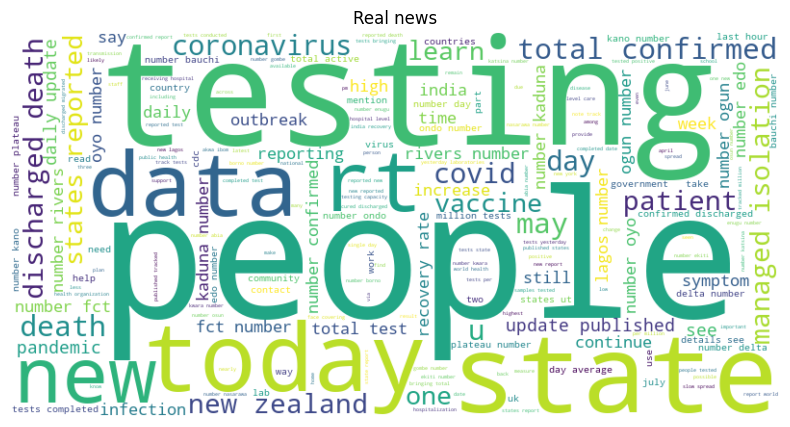

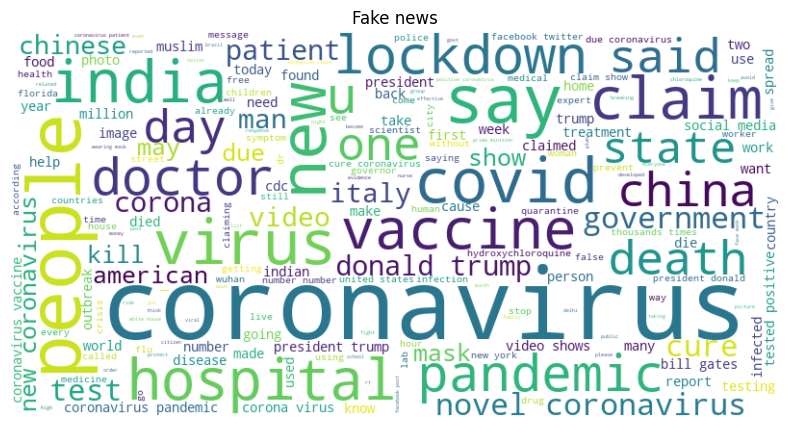

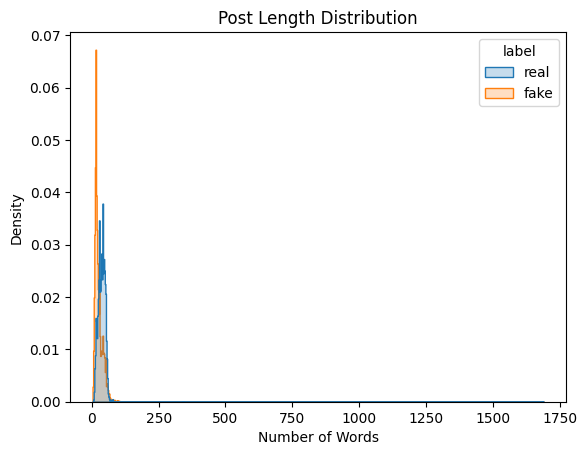

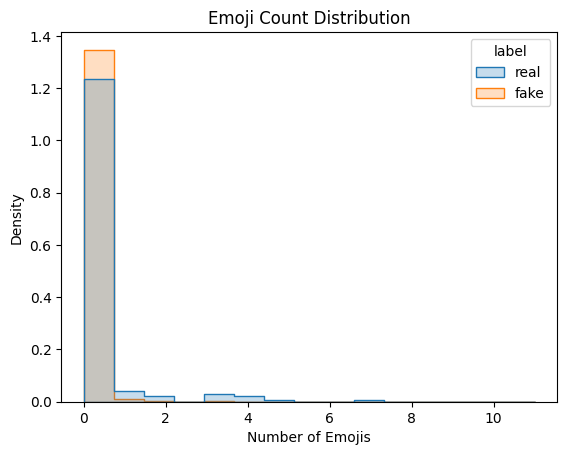

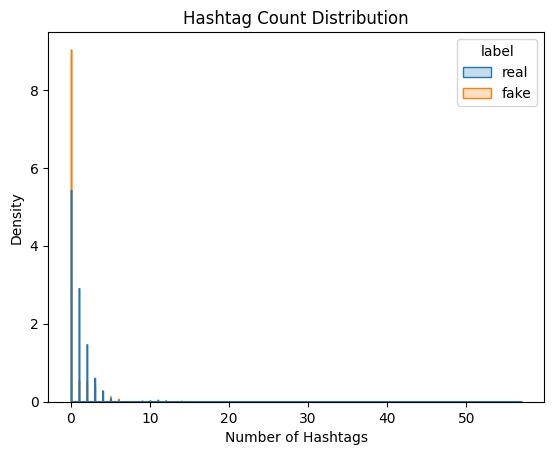

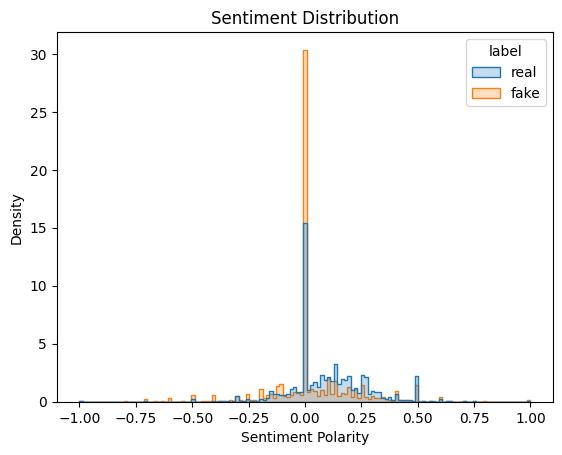

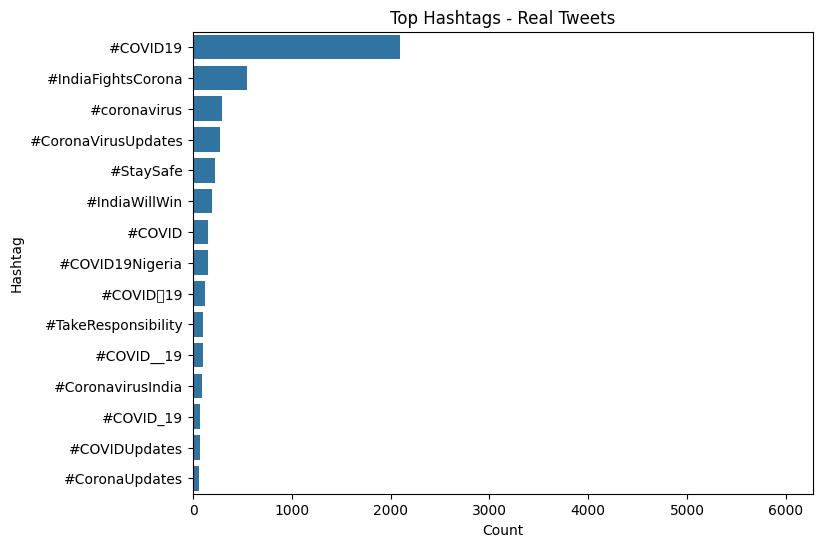

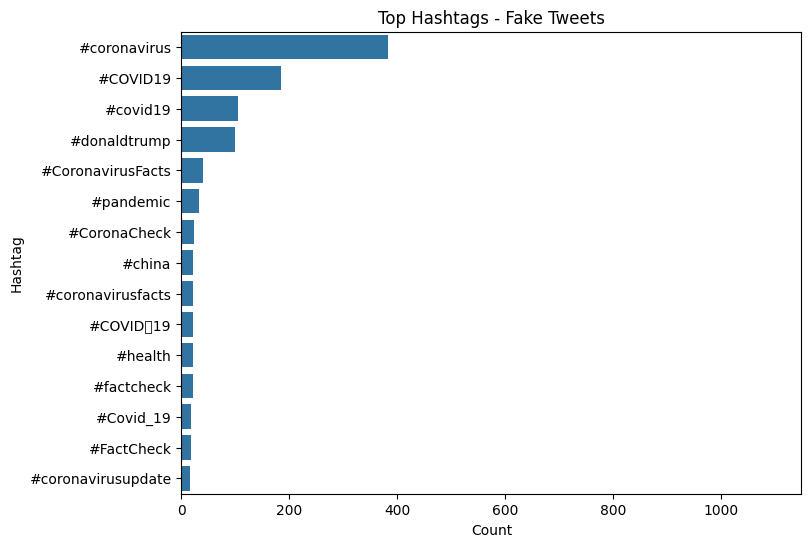


--- Top Words in Real Tweets (after removing common words) ---
[('new', 1452), ('tests', 1101), ('-', 956), ('%', 899), ('deaths', 885), ('states', 842), ('total', 840), ('’', 795), (')', 793), ('(', 778), ('people', 775), ('reported', 735), ('&', 721), ('confirmed', 718), ('testing', 691), ('today', 613), ('/', 546), ('report', 487), ('health', 477), ('state', 456)]

--- Top Words in Fake Tweets (after removing common words) ---
[('coronavirus', 1749), (',', 1692), ('"', 956), ('’', 600), ('people', 502), ('!', 492), ('virus', 395), ('trump', 383), ('new', 365), ('vaccine', 345), (')', 339), ('(', 339), ('covid', 333), ('�', 331), ('pandemic', 324), ('says', 322), ('india', 320), ('video', 313), ('”', 285), ('“', 273)]


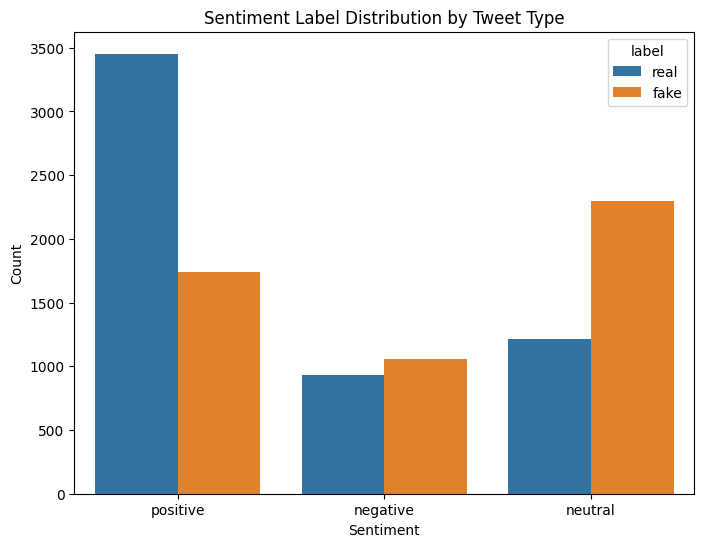

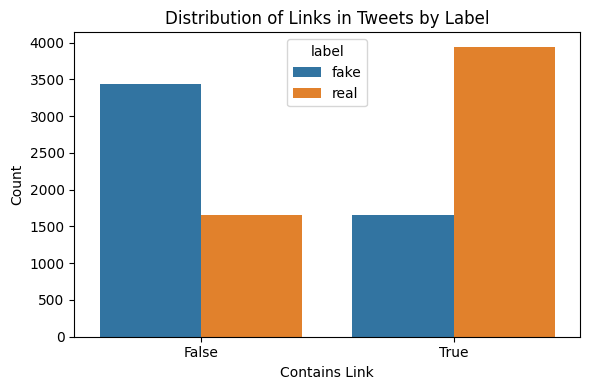


--- Number of Tweets by Label and Sentiment ---
  label sentiment_label  count
0  fake        negative   1056
1  fake         neutral   2301
2  fake        positive   1743
3  real        negative    931
4  real         neutral   1216
5  real        positive   3453
Saved processed data to /Users/samreade/Desktop/COMM 188C/processed_tweets.csv


In [82]:
common_words = common_words.union(standard_stopwords)

df['tokens_clean'] = df['tokens'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in common_words]
)

run_eda(df)

save_cols = [
    'tweet',
    'tokens',
    'tokens_clean',
    'label',
    'post_length',
    'emoji_count',
    'hashtag_count',
    'has_link',
    'sentiment',
    'sentiment_label'
]

output_path = "/Users/samreade/Desktop/COMM 188C/processed_tweets.csv"
df[save_cols].to_csv(output_path, index=False)
print(f"Saved processed data to {output_path}")

Accuracy: 0.9420560747663551

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1020
           1       0.94      0.95      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



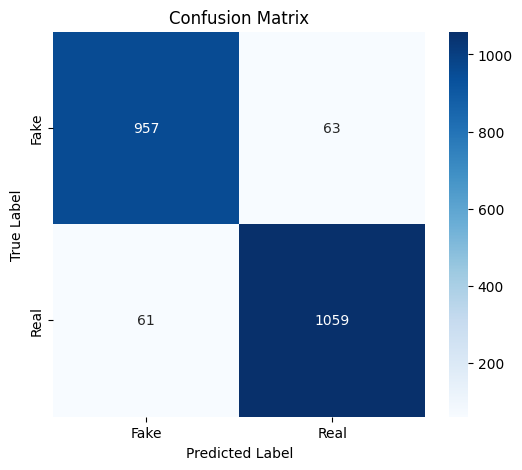

In [83]:
# === Feature Preparation ===
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

df['clean_text'] = df['tokens_clean'].apply(lambda tokens: ' '.join(tokens))

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df['clean_text'])

engineered_features = df[['post_length', 'emoji_count', 'hashtag_count', 'has_link', 'sentiment']].copy()
engineered_features['has_link'] = engineered_features['has_link'].astype(int)

X_combined = hstack([X_tfidf, engineered_features.values])

y = df['label'].map({'real': 1, 'fake': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.9271028037383178

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      1020
           1       0.92      0.94      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



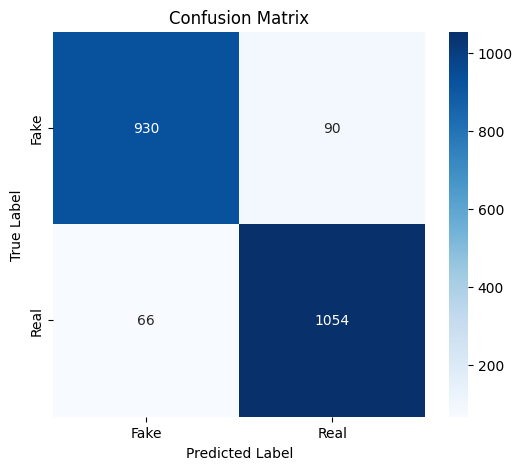

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

df['clean_text'] = df['tokens_clean'].apply(lambda tokens: ' '.join(tokens))

# Vectorizing
vectorizer = TfidfVectorizer(max_features=300, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Preparing structured features
structured_features = df[['post_length', 'emoji_count', 'hashtag_count', 'has_link', 'sentiment']].astype(float).values

from scipy.sparse import hstack
from scipy import sparse

X_structured_sparse = sparse.csr_matrix(structured_features)
X_full = hstack([X_tfidf, X_structured_sparse])
X_full = X_full.toarray()

# Labels
y = df['label'].map({'real': 1, 'fake': 0}).values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)

# Training Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [85]:
print("\nConfusion Matrix (2D):\n", cm)


Confusion Matrix (2D):
 [[ 930   90]
 [  66 1054]]


post_length          0.105285
has_link             0.079646
hashtag_count        0.070950
coronavirus          0.057507
sentiment            0.045076
rt                   0.020799
total                0.017945
trump                0.016058
indiafightscorona    0.013489
tests                0.013106
dtype: float64


/var/folders/q3/s37pw3_d24v6k85qr3x8kk200000gn/T/ipykernel_91875/310143613.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='coolwarm')


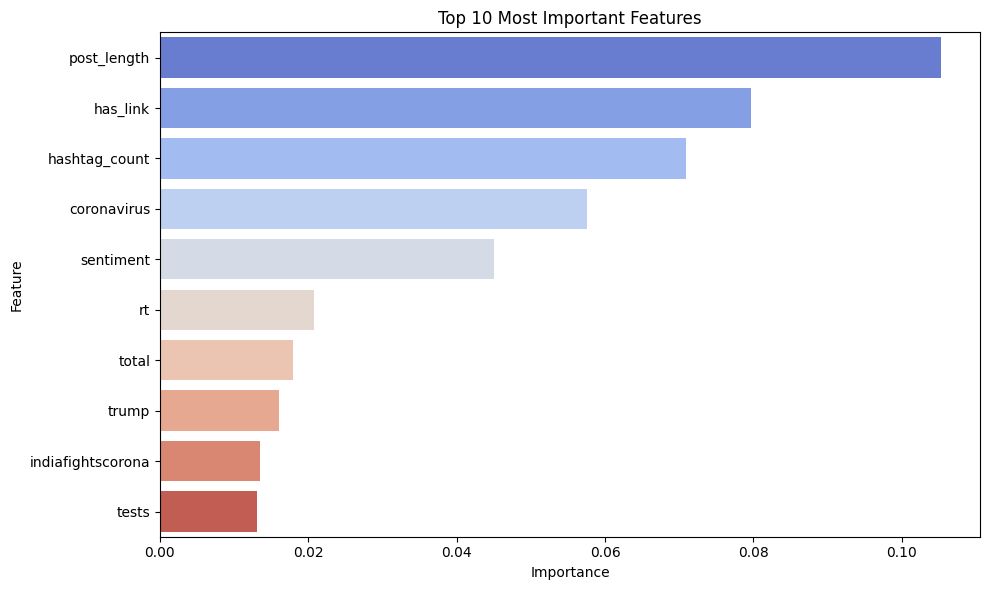

In [86]:
tfidf_feature_names = vectorizer.get_feature_names_out()
engineered_feature_names = engineered_features.columns.tolist()
all_feature_names = list(tfidf_feature_names) + engineered_feature_names

importances = rf.feature_importances_

feat_importances = pd.Series(importances, index=all_feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

print(feat_importances.head(10))

top_features = feat_importances.head(10).reset_index()
top_features.columns = ['feature', 'importance']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='feature', palette='coolwarm')  
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [87]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=all_feature_names,
    class_names=['fake', 'real'],
    mode='classification'
)

i = 0
exp = explainer.explain_instance(
    data_row=X_test[i],
    predict_fn=rf.predict_proba,
    num_features=10
)


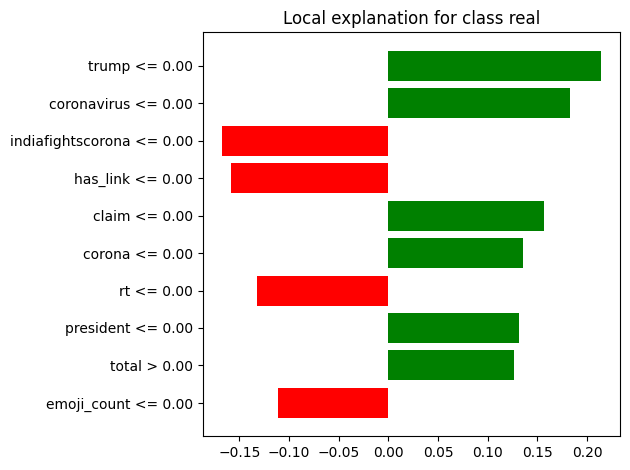

In [88]:
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


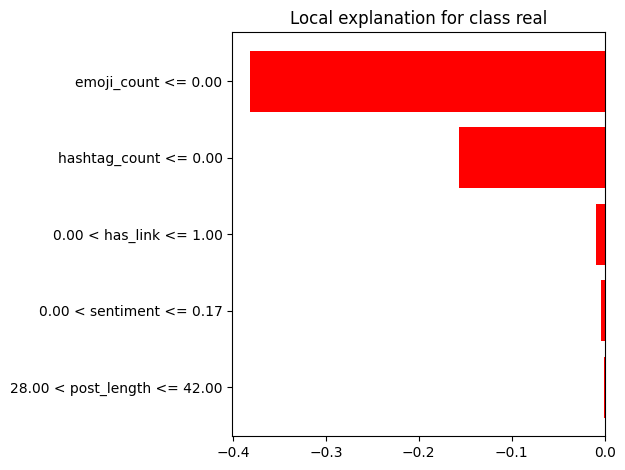

In [89]:

# Converting engineered features to NumPy and get feature names
engineered_np = engineered_features.values
engineered_feature_names = list(engineered_features.columns)
num_engineered_features = engineered_np.shape[1]

# Defining indices of engineered features (they come first in X_full)
engineered_feature_indices = list(range(num_engineered_features))

# Defining LIME-compatible prediction function
def lime_predict_fn(data_subset):
    """
    Reconstruct the full feature vector using only the engineered subset.
    TF-IDF part is filled with zeros.
    """
    full_input = np.zeros((data_subset.shape[0], X_full.shape[1]))
    full_input[:, engineered_feature_indices] = data_subset
    return rf.predict_proba(full_input)

# Setting up LIME explainer
explainer = LimeTabularExplainer(
    training_data=engineered_np,
    feature_names=engineered_feature_names,
    class_names=['fake', 'real'],  
    mode='classification'
)

# Explaining a prediction 
i = 0  
exp = explainer.explain_instance(
    data_row=engineered_np[i],
    predict_fn=lime_predict_fn,
    num_features=10  
)

# Displaying results
exp.show_in_notebook()  

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

In [90]:
import shap

In [69]:
X_train_dense = X_train
X_test_dense = X_test

explainer = shap.Explainer(rf, X_train_dense)

shap_values = explainer(X_test_dense)

 99%|===================| 4245/4280 [01:49<00:00]        

In [70]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

100%|===================| 4269/4280 [01:49<00:00]        

In [71]:
tfidf_feature_names = vectorizer.get_feature_names_out().tolist()
engineered_feature_names = engineered_features.columns.tolist()
all_feature_names = tfidf_feature_names + engineered_feature_names


In [72]:
shap_values.feature_names = all_feature_names

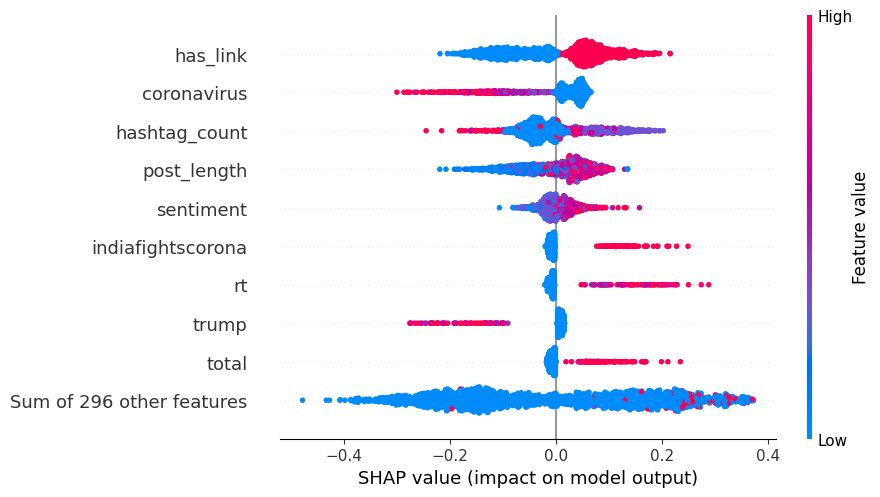

In [73]:
shap.plots.beeswarm(shap_values[:, :, 1])

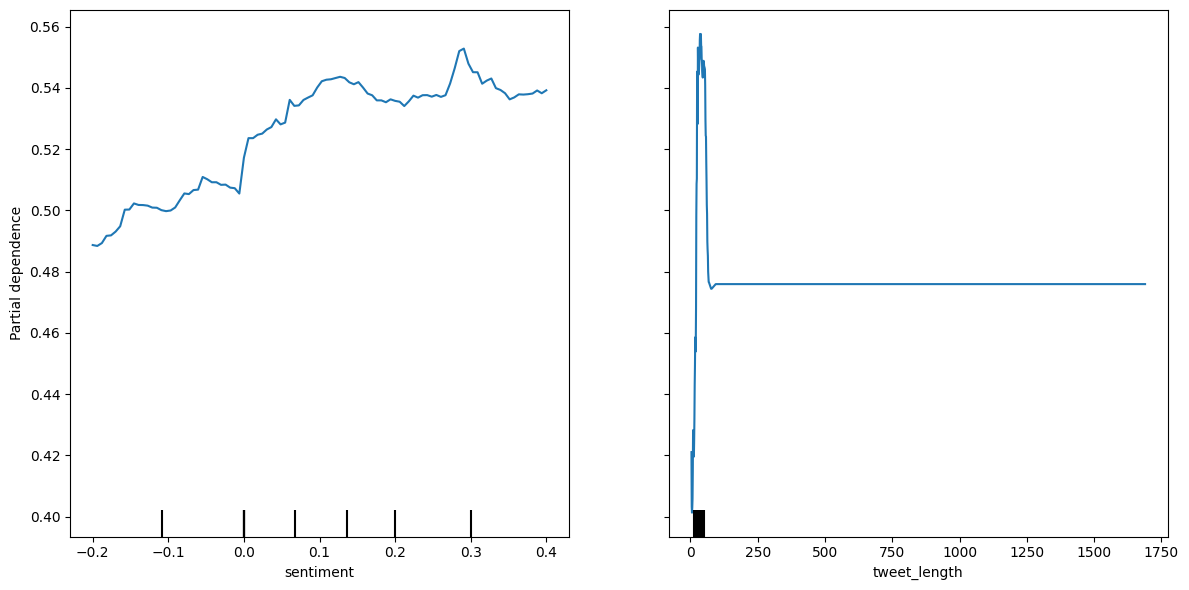

In [74]:
# PDPs:

from scipy.sparse import issparse
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

X_test_dense = X_test

tfidf_feature_names = vectorizer.get_feature_names_out()
engineered_feature_names = ['tweet_length', 'emoji_count', 'hashtag_count', 'has_link', 'sentiment']
feature_names = list(tfidf_feature_names) + engineered_feature_names

engineered_feature_indices = [
    len(tfidf_feature_names) + engineered_feature_names.index(feat)
    for feat in engineered_feature_names
]

features_to_plot = [
    len(tfidf_feature_names) + engineered_feature_names.index('sentiment'),
    len(tfidf_feature_names) + engineered_feature_names.index('tweet_length')
]

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf,
    X_test_dense,
    features=features_to_plot,
    feature_names=feature_names,
    ax=ax,
    kind='average'  
)
plt.tight_layout()
plt.show()
